In [1]:
import os
import pdb

from comet_ml import Experiment
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
from torch.nn import CrossEntropyLoss
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
import kornia.augmentation as K

from src.dataset import ClassificationDataset, NormalizeInstance, get_image_pair_filepaths, Resize, Chaos2DSegmentationDataset
from src.models import UNet
from src.metrics import dice_loss, dice_score
from src.utils import create_canvas
from src.train import train_one_epoch, validate
import src.config
from src.config import directories, Directories

%load_ext autoreload
%autoreload 2 # 0: off, 2: on for all modules
# os.chdir('CompositionalNets/')
# sys.path.append('/project/6052161/mattlk/workplace/CompNet')

# Change the below directory depending on where the CHAOS dataset is stored
data_dir = src.config.directories['chaos']

In [2]:
# experiment = Experiment(api_key="P5seMqEJjqZ8mDA7QYSuK3yUJ",
#                         project_name="chaos-liver-segmentation",
#                         workspace="matthew42", auto_metric_logging=False)

# Train U-Net on CHAOS for Liver Segmentation

In [3]:
def stack_normalize(x):
    x = np.stack((x, x, x), axis=2)
    x = (x - x.min()) / (x.max() - x.min() + 1e-12)
    x = x.astype(np.float32)
    return x

In [79]:
params = {
    "lr": 0.0001,
    "batch_size": 16,
    "split_train_val": 0.8,
    "epochs": 45,
    "use_dice_loss": False,
    "cache": False,
    "random_seed": 42,
    "shuffle_data": True,
    "scheduler": "StepLR",
    "step_size": 15,
    "gamma": 0.75,
    "threshold": 0.9,
    "pretrained": True,
}

is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")
input_images_dtype = torch.double
targets_dtype = torch.long
if is_cuda_available: torch.cuda.empty_cache()


size = (256, 256)
crop = (224, 224)
train_input_transform = transforms.Compose([
    stack_normalize,
    transforms.ToTensor(),
    Resize(size),
    K.CenterCrop(crop),
#     K.RandomAffine(degrees=(-5, 5), translate=(0.05, 0.05), scale=(0.75, 1.25)),
    transforms.Lambda(lambda x: x.squeeze()),
])

train_target_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype(np.uint8)),
    transforms.ToPILImage(),
    transforms.Resize(size),
    transforms.CenterCrop(crop),
    transforms.ToTensor(),
#     K.RandomAffine(degrees=(-5, 5), translate=(0.05, 0.05), scale=(0.75, 1.25)),
    transforms.Lambda(lambda x: x.squeeze()),
    transforms.Lambda(lambda x: x*255),
    transforms.Lambda(lambda x: x.long()),
])

val_input_transform = transforms.Compose([
    stack_normalize,
    transforms.ToTensor(),
    Resize(size),
    K.CenterCrop(crop),
    transforms.Lambda(lambda x: x.squeeze()),
])
val_target_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype(np.uint8)),
    transforms.ToPILImage(),
    transforms.Resize(size),
    transforms.CenterCrop(crop),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255),
    transforms.Lambda(lambda x: x.long()),
])

data_dir = Directories.CHAOS

image_pair_filepaths = get_image_pair_filepaths(data_dir)[:]
train_filepaths, val_filepaths = train_test_split(image_pair_filepaths,
                                                  train_size=params['split_train_val'],
                                                  random_state=params['random_seed'],
                                                  shuffle=params["shuffle_data"])

train_dataset = Chaos2DSegmentationDataset(train_filepaths, 
                                           input_transform=train_input_transform,
                                           target_transform=train_target_transform,
                                           cache=params['cache'])

val_dataset = Chaos2DSegmentationDataset(val_filepaths,
                                         input_transform=val_input_transform,
                                         target_transform=val_target_transform,
                                         cache=params['cache'])

num_train, num_val = len(train_dataset), len(val_dataset)
params['num_samples'] = num_train + num_val
params['input_transform'] = train_input_transform.__str__()
params['target_transform'] = train_target_transform.__str__()

train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=True)

In [80]:
image, target = train_dataset[42]
image = image.clone().permute(1, 2, 0).numpy()
target = target.clone().numpy()
img = create_canvas(image, target, show=False,
                           title1='Example Input', title2='Example Target')
img

TypeError: Input type float32 is not supported

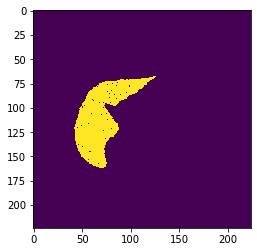

In [78]:
plt.imshow(target)

In [94]:
def validate(net, dataloader, epoch, device=None, input_dtype=torch.double,
    target_dtype=torch.long, use_dice_loss=False, experiment=None,
    batch_freq=50, epoch_freq=25, threshold=0.5, **kwargs):
    from src.metrics import jaccard_score, dice_score
    import torch.nn.functional as F
    """Gather validation metrics (Dice, Jaccard) on neural network
    """
    net.eval()
    torch.set_grad_enabled(False)
    dice_mean = torch.zeros((1), device=device)
    jaccard_mean = torch.zeros((1), device=device)

    for i, data in enumerate(dataloader):

        input_images, targets = data

        if device:
            input_images = input_images.to(device, input_dtype)
            targets = targets.to(device, target_dtype)

        outputs = net(input_images)

        if use_dice_loss:
            outputs = F.log_softmax(outputs, dim=1)
        else:
            outputs = F.softmax(outputs, dim=1)
            outputs = F.threshold(outputs[:, 1, :, :].unsqueeze(dim=1), threshold, 0)
            outputs = torch.round(outputs)

        score = dice_score(outputs, targets)
        dice_mean = dice_mean + (score - dice_mean) / (i + 1)
        score = jaccard_score(outputs, targets)
        jaccard_mean = jaccard_mean + (score - jaccard_mean) / (i + 1)

#         outputs, targets = outputs.data.cpu().numpy()*255, targets.data.cpu().numpy()*255
#         for idx, (out, gt) in enumerate(zip(outputs, targets)):
#             img = create_canvas(out, gt, show=False)
#             plt.figure(figsize=(10, 10))
#             plt.imshow(img)

    return dice_mean.item(), jaccard_mean.item()

In [94]:
%%time
# with experiment.train():
num_accumulated_steps = 1

print(f'Number of training images:\t{num_train}\nNumber of validation images:\t{num_val}')
for epoch in range(params['epochs']):

    unet, running_loss = train_one_epoch(unet, train_dataloader, optimizer,
                                         criterion, device=device,
                                         num_accumulated_steps=num_accumulated_steps, 
                                         **params)

    if params['use_dice_loss']:
        print(f'[Epoch {epoch+1:03d} Training]\tDice Loss:\t\t{running_loss:.4f}')
    else:
        print(f'[Epoch {epoch+1:03d} Training]\tCross-Entropy Loss:\t{running_loss:.4f}')
#     experiment.log_metric("Running Loss", running_loss, epoch=epoch, step=epoch, include_context=False)

    f1_mean, jaccard_mean = validate(unet, val_dataloader, epoch, device,
#                                      experiment=experiment, batch_freq=25,
                                     experiment=None, batch_freq=25,
                                     epoch_freq=25, **params)

    if params['scheduler'] == 'ReduceLROnPlateau':
        scheduler.step(f1_mean)
    else:
        scheduler.step()
    print(f'[Epoch {epoch+1:03d} Validation]\tAverage F1 Score:\t{f1_mean:.4f}\tAverage Jaccard/IoU:\t{jaccard_mean:.4f}\n')

#     experiment.log_metric('Validation Average F1 Score', f1_mean,
#                           epoch=epoch, include_context=False)
#     experiment.log_metric('Validation Average Jaccard/IoU', jaccard_mean,
#                           epoch=epoch, include_context=False)

# torch.save(unet.state_dict(), 'unet.pth')
# experiment.log_asset('unet.pth', copy_to_tmp=False)
# experiment.end()

KeyboardInterrupt: 